In [2]:
# Установка PyTorch
!pip install -U torch torchvision
!pip install wheel==0.34.1

In [3]:
import torch
print(torch.__version__ )
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

2.2.1
CUDA is not available.  Training on CPU ...


In [4]:
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
# Импорт необходимых библиотек
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [6]:
# Датасет состоит из +-7000 фотографий. Он поделен на 3 части. train - для терировки модели. test - для тестирования.
# val (validation) - тоже для тестирования, только ручного. Там всего около 150 фото
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 256
# Выбираем либо cpu, либо cuda. На винде и линукс поддерживается cuda
DEVICE = torch.device("cpu")

In [8]:
import csv
from pathlib import Path

class CarDamageDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            # Укажи свой путь к файлу csv в папке
            csv_file_path = /ai/Damaged_Cars/train/_annotations.csv'

            self.labels = []

            with open(csv_file_path, newline='') as csvfile:
                csvreader = list(csv.DictReader(csvfile))

                file_paths = [Path(path) for path in self.files]

                for path in file_paths:
                    for row in csvreader:
                        if row['filename'] == path.name:
                            self.labels.append(row['class'])

            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
            
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)


In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
import os
os.listdir("/ai/Damaged_Cars")

['valid', '.DS_Store', 'test', 'train']

In [11]:
import csv
# Укажи свой путь к csv файлу
csv_file_path = '/ai/Damaged_Cars/train/_annotations.csv'

with open(csv_file_path, newline='') as csvfile:
    csvreader = csv.DictReader(csvfile)

In [12]:
# Укажи свой путь к картинкам для тренировки модели
TRAIN_DIR = Path('/ai/Damaged_Cars/train')
# Укажи свой путь к картинкам для тестирования модели
TEST_DIR = Path('/ai/Damaged_Cars/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
from sklearn.model_selection import train_test_split
import csv

# Укажи свой путь к csv файлу
csv_file_path = '/ai/Damaged_Cars/train/_annotations.csv'

train_val_labels = []

# Считываем имена файлов из CSV файла
with open(csv_file_path, newline='') as csvfile:
    csvreader = list(csv.DictReader(csvfile))
    train_val_files = [row['filename'] for row in csvreader]

    for row in csvreader:
        train_val_labels.append(row['class'])

train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)


In [15]:
val_dataset = CarDamageDataset(val_files, mode='val')
len(val_dataset)

2059

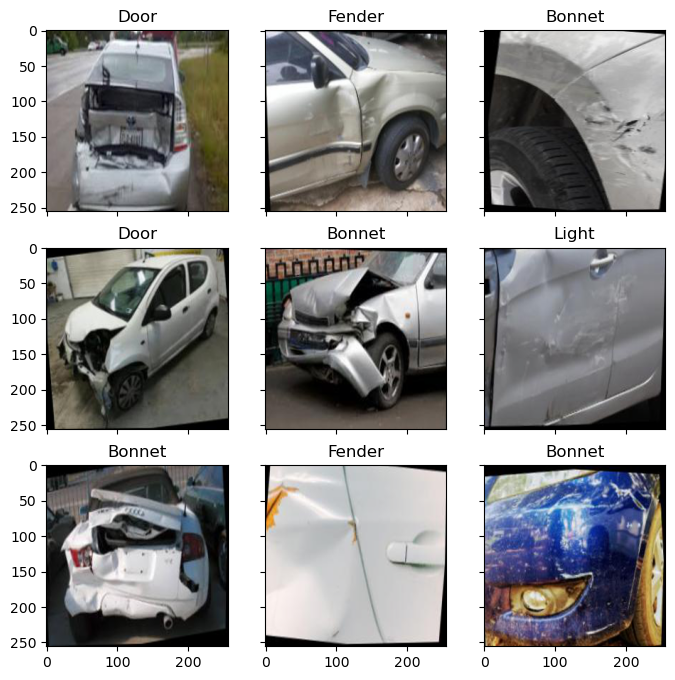

In [16]:
# Пример рандомно выведенных картинок из нашего датасета и их классификация, как указанно в нашем csv файле.
# Всего у нас 7 классификаций повреждений. И уже на этом этапе мы можем оценить насколько у нас кривой датасет
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,2000))
    im_val, label = val_dataset[random_characters]
    img_label = train_val_labels[random_characters]
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [17]:
# Начинаем подготовку к обучению нашей модельки. Если не собираешся ее перобучать, то этот код не запускай
def fit_epoch(model, train_loader, criterion, optimizer):

    model.train(True)

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.cpu()
        labels = labels.cpu()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.cpu()
        labels = labels.cpu()

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:04d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.cpu()
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)


for param in resnet.parameters():
    param.requires_grad = False

layers = list(resnet.children())
for layer in layers[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

In [22]:
in_features = 2048
out_features = 7
resnet.fc = nn.Linear(in_features, out_features)

In [23]:
if val_dataset is None:
    val_dataset = CarDamageDataset(val_files, mode='val')

train_dataset = CarDamageDataset(train_files, mode='train')

In [24]:
# Процесс обучения модели
history = train(train_dataset, val_dataset, model=resnet, epochs=10, batch_size=64)

epoch:   0%|                                             | 0/10 [00:00<?, ?it/s]

loss 1.743148908619744


epoch:  10%|███▎                             | 1/10 [20:27<3:04:08, 1227.61s/it]


Epoch 0001 train_loss: 1.7431     val_loss 1.8559 train_acc 0.3035 val_acc 0.2739
loss 1.5033026607711666


epoch:  20%|██████▌                          | 2/10 [41:58<2:48:37, 1264.74s/it]


Epoch 0002 train_loss: 1.5033     val_loss 1.8991 train_acc 0.3719 val_acc 0.2210
loss 1.2733592663225048


epoch:  30%|█████████▎                     | 3/10 [1:04:19<2:31:35, 1299.42s/it]


Epoch 0003 train_loss: 1.2734     val_loss 2.0914 train_acc 0.4601 val_acc 0.2215
loss 1.0699248042561311


epoch:  40%|████████████▍                  | 4/10 [1:26:54<2:12:09, 1321.51s/it]


Epoch 0004 train_loss: 1.0699     val_loss 2.4432 train_acc 0.5443 val_acc 0.2220
loss 0.9267023980125402


epoch:  50%|███████████████▌               | 5/10 [1:48:26<1:49:13, 1310.79s/it]


Epoch 0005 train_loss: 0.9267     val_loss 2.5967 train_acc 0.5925 val_acc 0.2190
loss 0.8194362745135275


epoch:  60%|██████████████████▌            | 6/10 [2:09:51<1:26:48, 1302.13s/it]


Epoch 0006 train_loss: 0.8194     val_loss 2.9614 train_acc 0.6145 val_acc 0.2288
loss 0.7429219059849974


epoch:  70%|█████████████████████▋         | 7/10 [2:31:48<1:05:20, 1306.97s/it]


Epoch 0007 train_loss: 0.7429     val_loss 3.0727 train_acc 0.6252 val_acc 0.2215
loss 0.6959490843222175


epoch:  80%|██████████████████████████▍      | 8/10 [2:54:08<43:54, 1317.42s/it]


Epoch 0008 train_loss: 0.6959     val_loss 3.4722 train_acc 0.6257 val_acc 0.2035
loss 0.6467520357220424


epoch:  90%|█████████████████████████████▋   | 9/10 [3:16:19<22:01, 1321.66s/it]


Epoch 0009 train_loss: 0.6468     val_loss 3.7901 train_acc 0.6362 val_acc 0.2093
loss 0.6268993299312724


epoch: 100%|████████████████████████████████| 10/10 [3:39:10<00:00, 1315.06s/it]


Epoch 0010 train_loss: 0.6269     val_loss 3.5171 train_acc 0.6387 val_acc 0.2054


In [ ]:
# Процесс обучени занял 3 часа и 40 минут. Точность модели после окончания обучения составляет около 64%

In [25]:
loss, acc, val_loss, val_acc = zip(*history)
print(loss, acc, val_loss, val_acc)

(1.743148908619744, 1.5033026607711666, 1.2733592663225048, 1.0699248042561311, 0.9267023980125402, 0.8194362745135275, 0.7429219059849974, 0.6959490843222175, 0.6467520357220424, 0.6268993299312724) (0.30354541039339483, 0.37186336409260157, 0.460093896713615, 0.5442771571960499, 0.5925206410879067, 0.6145378015217743, 0.6252225999676219, 0.6257082726242512, 0.6362311801845556, 0.6386595434677028) (1.8559262619949533, 1.8990806022739457, 2.091379658350266, 2.443158061368886, 2.5967418961064106, 2.961351327145777, 3.072664330803462, 3.472217607984501, 3.7900907772151284, 3.5170516428176266) (tensor(0.2739, dtype=torch.float64), tensor(0.2210, dtype=torch.float64), tensor(0.2215, dtype=torch.float64), tensor(0.2220, dtype=torch.float64), tensor(0.2190, dtype=torch.float64), tensor(0.2288, dtype=torch.float64), tensor(0.2215, dtype=torch.float64), tensor(0.2035, dtype=torch.float64), tensor(0.2093, dtype=torch.float64), tensor(0.2054, dtype=torch.float64))


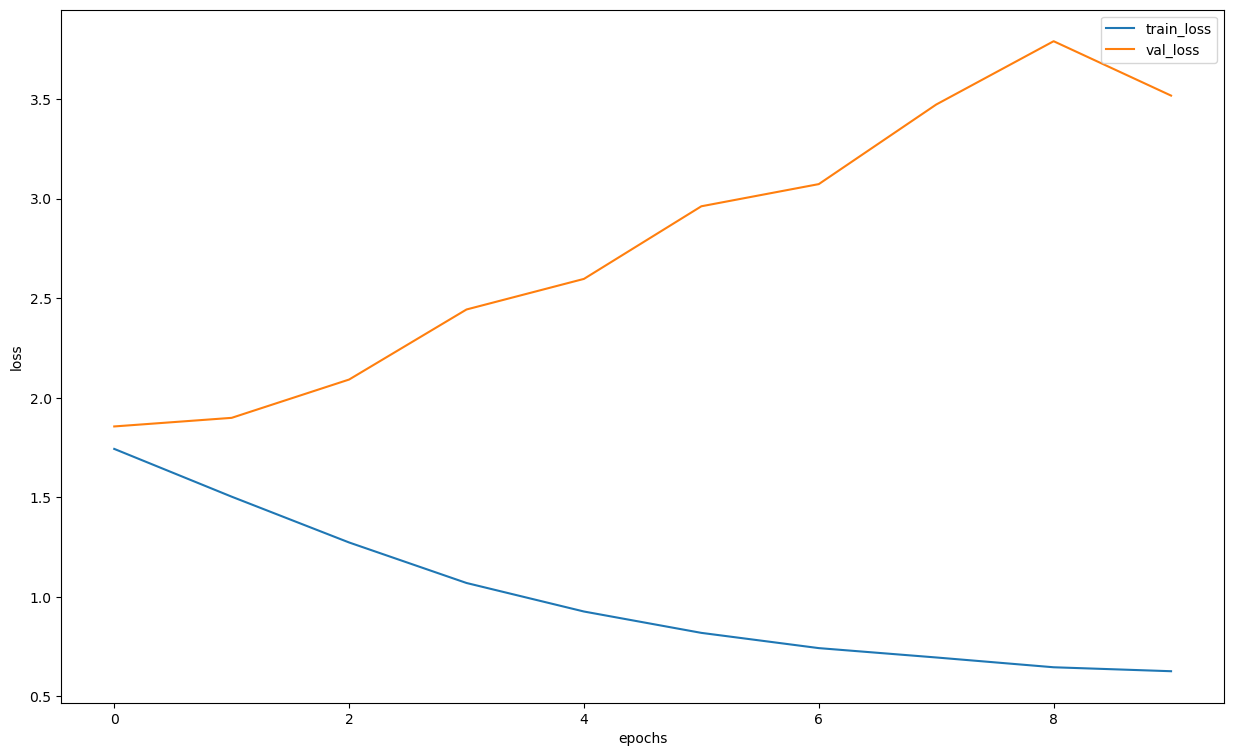

In [26]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [27]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.cpu()
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [28]:
random_characters = int(np.random.uniform(0,15))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet, ex_img.unsqueeze(0))

In [29]:
idxs = list(map(int, np.random.uniform(0,15, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(resnet, imgs)

In [30]:
# Открываем уже натренированную модель
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [31]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [32]:
# Сходимость значений
from sklearn.metrics import f1_score
f1_score(actual_labels, y_pred, average='micro')

0.25

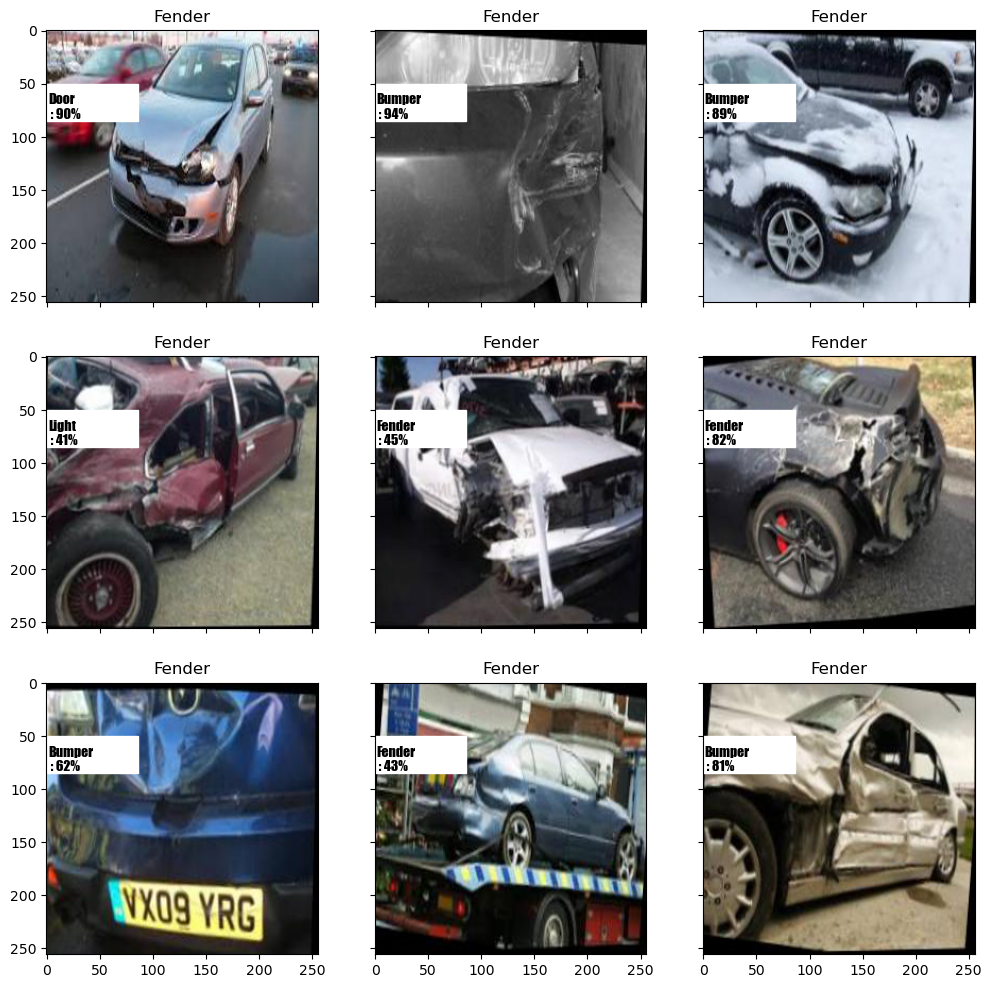

In [39]:
# Проверяем как работает наша модель. Пишет класс повреждения и процент точности определения класса
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,2000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 50),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)] + '\n' + predicted_label[len(predicted_label):]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')

### Testing

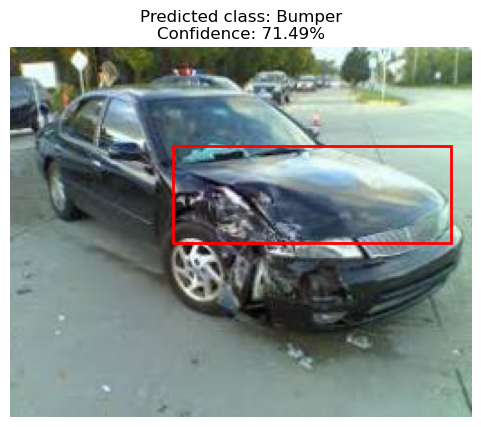

In [67]:
# Ручное тестирование
import pandas as pd
# Для теста мы берем специально выделенную часть датасета valid. Указываем путь к csv файлу, хранящимся в данной папке
annotations_df = pd.read_csv('/Users/lerapolovinkina/PycharmProjects/ai/1/CarDamageDetection/valid/annotations1.csv')

def get_coordinates(image_path):
    basename = os.path.basename(image_path)
    image_id = os.path.splitext(basename)[0]
    row = annotations_df[annotations_df['filename'] == image_path]
    if row.empty:
        print(f"No coordinates found for image: {image_id}")
        return None, None, None, None
    xmin = row['xmin'].values[0]
    ymin = row['ymin'].values[0]
    xmax = row['xmax'].values[0]
    ymax = row['ymax'].values[0]
    return xmin, ymin, xmax, ymax

# Указываем название картинки из папки valid
image_path = "/Users/lerapolovinkina/PycharmProjects/ai/1/CarDamageDetection/valid/0071_JPEG.rf.ab6fbb2c84b066fb84466a65314ea59f.jpg"
xmin, ymin, xmax, ymax = get_coordinates(image_path)
predict_and_visualize(resnet, image_path, label_encoder, xmin, ymin, xmax, ymax)
